###Project name -- Development of functional connectivities in zebrafish spinal cord### 

###Current stage###
1. Remove non-active units in the dataset
2. Covariance analysis: factor analysis

###Dataset list###
* Data_Dre_E1_BTXinjHuCH2BGCaMP6f_TL_20140818_045650_corrected_signal (2014-10-01)
* (-) Data_Dre_E1_HuCH2BGCaMP6f_0_20141006_041947_corrected (2014-11-01)
* Data_Dre_E1_HuCH2BGCaMP6f_0_20141006_041947_corrected (2015-01-14)
* Data_Dre_E1_HuCGCaMP6f-__mnx1__TagRFP_0-1_20150410_032910.corrected (2015-07-20)

###Removing the nonactive neurons using std threshold
* Test Method (see __notebook_01__)
* Results -- the amplitude of std may __not be enough__ to reflect the amount of signal in the data
* Related files:
    * Data_Analysis_List2_0_5
    * __Data_Analysis_List2_0_6__

In [1]:
%load_ext pymatbridge
import pymatbridge as pymat 
ip = get_ipython()
pymat.load_ipython_extension(ip)

Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-915c5d19-1fb9-498b-8c5a-23dbdf865e15
Send 'exit' command to kill the server
.........MATLAB started and connected!



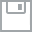
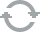
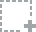
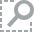
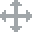
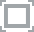
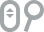
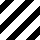
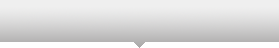
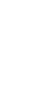
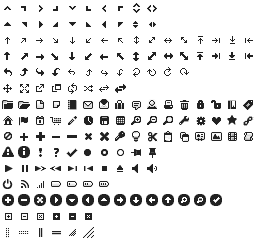
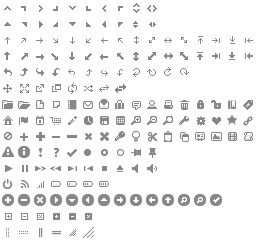
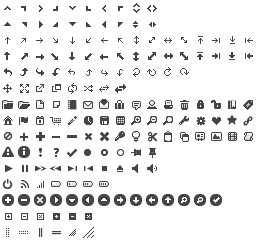
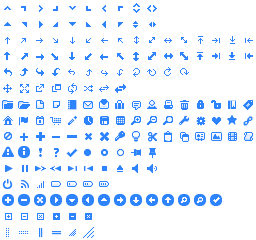
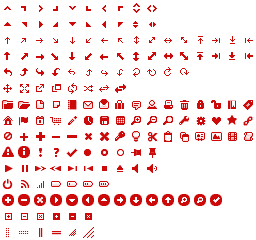
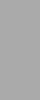
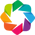
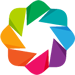

In [2]:
from bokeh.plotting import figure, output_notebook, show
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
output_notebook()
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.io as sio
tempDatDir = '../../TempDat/'
fileNames = ('Data_Dre_E1_HuCH2BGCaMP6f_0_20141006_041947_corrected', \
             'Data_Dre_E1_BTXinjHuCH2BGCaMP6f_TL_20140818_045650_corrected_signal')

####Test

* nFile: file name index (see __Dataset List__)
* dffThres : threshold to pick up active neurons according to their raw std.

In [5]:
# %%matlab
# nFile = 1;
# # dffThres = 0.01;
# # Data_Analysis_List2_0_5(nFile, dffThres);
# # Data_Analysis_List2_0_6(nFile);

# dffThres = 0.03;
# Data_Analysis_List2_0_5(nFile, dffThres);
# Data_Analysis_List2_0_6(nFile);

# # nFile = 2;
# # dffThres = 0.03;
# # Data_Analysis_List2_0_5(nFile, dffThres);
# # Data_Analysis_List2_0_6(nFile);

###Removing the nonactive neurons using normality test
* Test Method: Kolmogorov-Smirnov test (Null hypothesis: samples from normal distribution) as spetrogram (__sample window = 1024__)
* Related files:
    * __Data_Analysis_List2_7_7__

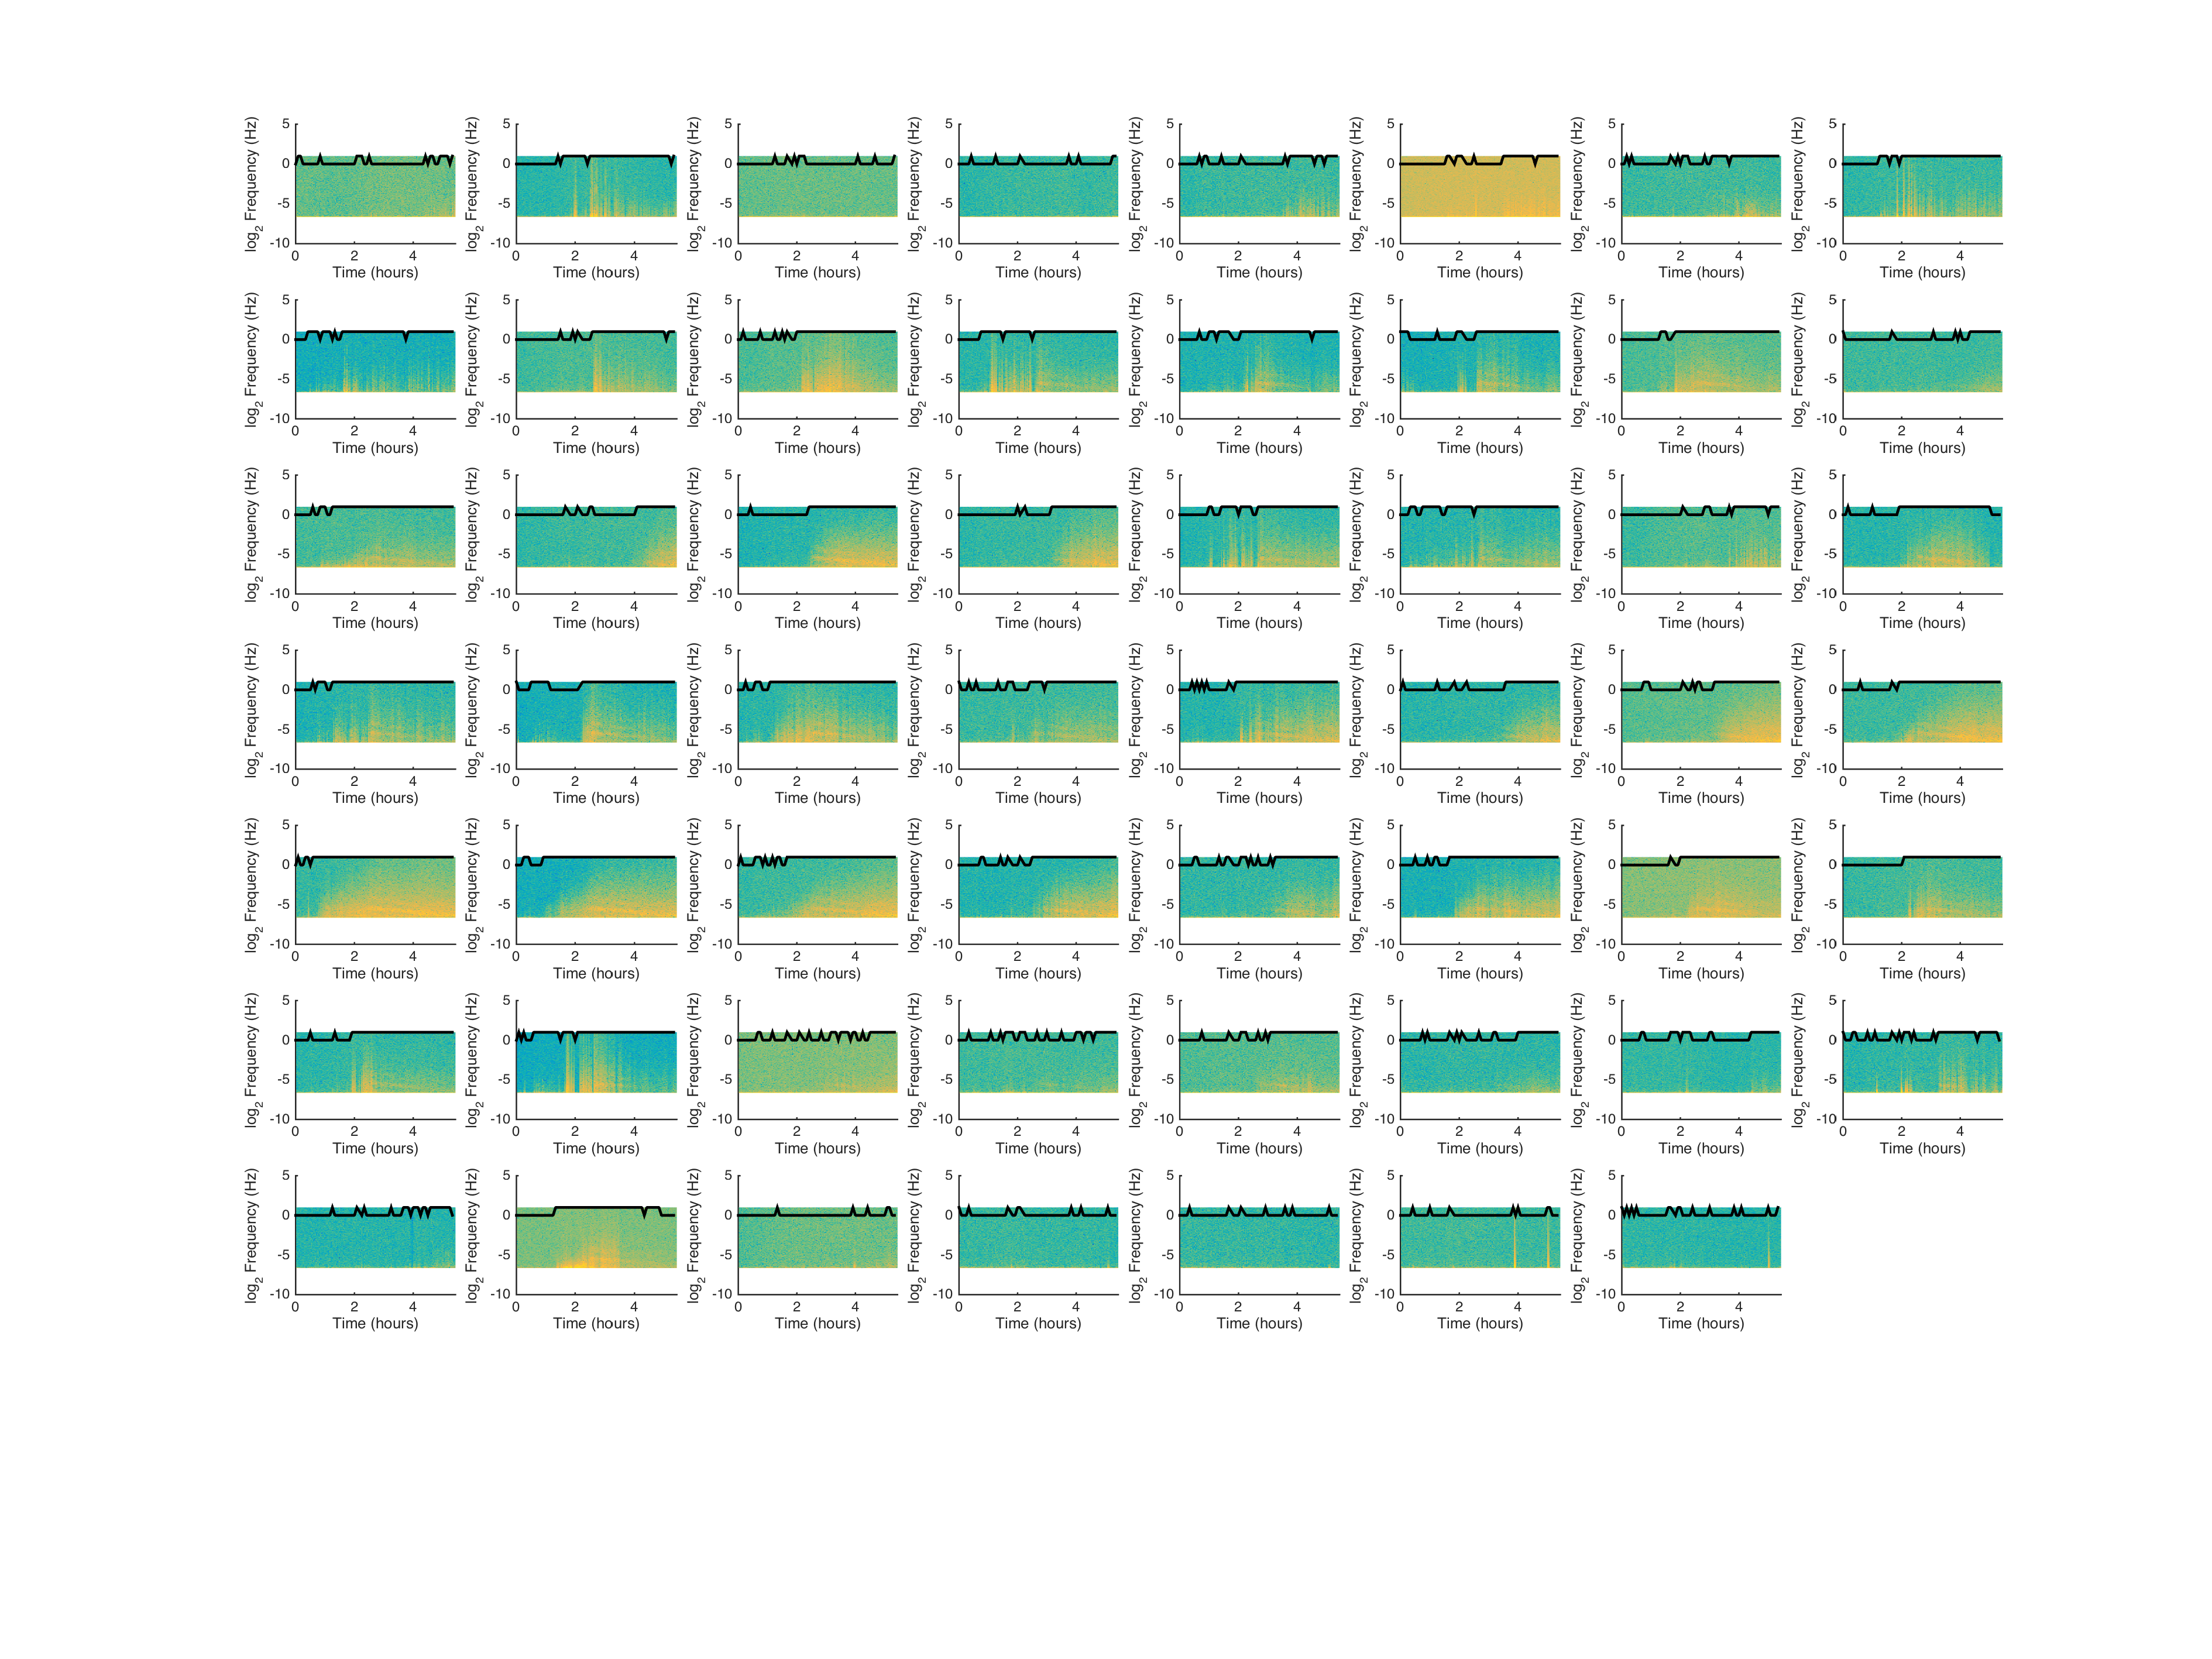

In [9]:
%%matlab
nFile = 1;
Data_Analysis_List2_7_7(nFile)

In [ ]:
# %%matlab
# nFile = 2;
# Data_Analysis_List2_7_7(nFile)

###Removing the active neurons with high power in DC mode (where mean is removed)
* Test Method: Welch's methods (__sample window = 128__)
* Related files:
    * __Data_Analysis_List2_7_8__
    * Data_Analysis_List2_0_7
    * Data_Analysis_List2_0_8
    * Data_Analysis_List2_0_9
    * __Data_Analysis_List2_1_0__

#### Test for analysis

In [ ]:
%%matlab -o dff -o timePoints -o PSDPeakTime

nFile = 1;
addpath('../Func');
setDir;    
fileName      = fileNames{nFile};
load([tempDatDir, fileName, '.mat'], 'dff','timePoints');
numNeuron     = size(dff, 1);

PSDPeakTime   = nan(size(dff, 1), length(timePoints)-1);
hannWindow    = 128;
noverlap      = hannWindow/2;
nfft          = hannWindow;
fs            = 4;
vecHannWin    = hann(hannWindow);

for nTime = 1:length(timePoints)-1
    slicedDFF     = dff(:,timePoints(nTime)+1:timePoints(nTime+1));
    slicedDFF     = bsxfun(@minus, slicedDFF, mean(slicedDFF,2));
    slicedDFF     = bsxfun(@rdivide, slicedDFF, std(slicedDFF,[],2))';
    for nNeuron   = 1:numNeuron
        if kstest(slicedDFF(:, nNeuron));
            [fftDff, f] = pwelch(slicedDFF(:, nNeuron), vecHannWin, noverlap, nfft, fs);
            [~, maxFIndex] = max(fftDff);
            PSDPeakTime(nNeuron, nTime) = f(maxFIndex);
        end
    end
end

In [ ]:
nTime = 35 
nTime = nTime - 1
hannWindow    = 128
fs = 4
timeIndex = np.arange(timePoints[0, nTime+1] - (timePoints[0, nTime]+1))/4
numCLine = np.ceil(hannWindow/fs)


pbokeh = figure(tools="pan,box_zoom,reset,save, wheel_zoom", \
                x_axis_label='Time (s)', \
                y_axis_label='Normalized data',
                plot_width=1000, plot_height = 300) #y_axis_type="log", y_range=[0.001, 10**11], title="",

for nNeuron in np.arange(dff.shape[0]):
    slicedDFF     = dff[nNeuron,timePoints[0, nTime]+1:timePoints[0, nTime+1]]
#     slicedDFF     = (slicedDFF - slicedDFF.mean())/slicedDFF.std()
    if (np.isnan(PSDPeakTime[nNeuron, nTime])):
        pbokeh.line(timeIndex, slicedDFF + nNeuron*5, line_color = 'black')
    elif (PSDPeakTime[nNeuron, nTime] == 0):
        pbokeh.line(timeIndex, slicedDFF + nNeuron*5, line_color = 'gray')
    else:
        (r, g, b, a) = cm.jet(1/PSDPeakTime[nNeuron, nTime]/numCLine)
        r         = np.floor(r*255)
        g         = np.floor(g*255)
        b         = np.floor(b*255)
        pbokeh.line(timeIndex, slicedDFF + nNeuron*5, line_color = "#%02x%02x%02x" % (r, g, b))

# show the results
show(pbokeh)


In [ ]:
hannWindow    = 128
fs = 4

fig, ax = plt.subplots(figsize = (8, 6))
sioLoadmat = sio.loadmat(tempDatDir+fileNames[0]+'_PSDPeakTime.mat')
nPSDPeakTime = sioLoadmat['PSDPeakTime']
ax.matshow(1./nPSDPeakTime, cmap = cm.PuRd, aspect="auto", \
           extent=[0, nPSDPeakTime.shape[1]*5/60, 0, nPSDPeakTime.shape[0]],
          origin='lower') 
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Neuronal Index')
ax.set_title(fileNames[0])

fig, ax = plt.subplots(figsize = (8, 6))
sioLoadmat = sio.loadmat(tempDatDir+fileNames[1]+'_PSDPeakTime.mat')
nPSDPeakTime = sioLoadmat['PSDPeakTime']
ax.matshow(1./nPSDPeakTime, cmap = cm.PuRd, aspect="auto", \
           extent=[0, nPSDPeakTime.shape[1]*5/60, 0, nPSDPeakTime.shape[0]])
ax.set_xlabel('Time (hour)')
ax.set_ylabel('Neuronal Index')
ax.set_title(fileNames[1])

In [ ]:
%%matlab
for nFile = 1:2
    Data_Analysis_List2_1_0(nFile)
end

In [ ]:
# %matlab exit